## 内容：
基于transformer分类故障，再利用注意力权重做可解释。


## 数据：
CWRU： 正常 + 3种故障程度*（外圈+内圈+滚子） = 10种类别

B022:  正常 + 2种故障程度*（外圈+内圈+滚子）= 7种类别


In [1]:
# 22-9-5
import numpy as np
import tensorflow as tf
import scipy
import scipy.io as scio
from scipy import signal
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import pywt
from tqdm import tqdm
from sklearn.manifold import TSNE
from collections import Counter



print(tf.__version__, tf.config.experimental.get_device_details(tf.config.list_physical_devices('GPU')[0]))

2024-04-12 20:17:35.476978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1 {'compute_capability': (6, 1), 'device_name': 'NVIDIA GeForce GTX 1070'}


2024-04-12 20:17:37.168424: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-12 20:17:37.169147: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-12 20:17:37.243857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 20:17:37.244275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.645GHz coreCount: 16 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 238.66GiB/s
2024-04-12 20:17:37.244300: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-04-12 20:17:37.246212: I tensorflow/stream_executor/platform/de

# 全局设置

In [2]:
# print(plt.rcParams.keys())

plt.rcParams.update({
    #'font.family':   'Times New Roman'   ,   # monospace   "Times New Roman"  cursive
    
    'font.size': 10,
    
    'figure.dpi': 150,         
    # dpi=150,显示得图片大小合适，保存时，设置更高dpi即可
    
    'axes.titlesize':  10,
    'axes.labelsize':  10,
    
    'legend.fontsize':  9,
    'legend.edgecolor': '0.5',
    'legend.fancybox':  False,
    'legend.markerscale': 1.0,
    'legend.frameon': False,
    
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    
    
    'savefig.dpi': 600,
    
    
})


# 22-9-5
def get_date():
    now_time = list(time.localtime(time.time()))
    now_time = '_TIME-({0:4d}-{1:02d}-{2:02d})-({3:02d}-{4:02d}-{5:02d})_'.format(
                now_time[0], now_time[1], now_time[2], 
                now_time[3], now_time[4], now_time[5], )
    return now_time
now_time = get_date()
print(now_time)


Health_status = ['NC','OF1','IF1','RF1',   'OF2','IF2','RF2',   'OF3','IF3','RF3']

def normalF(x):
    mean = np.mean(x)
    std = np.std(x)
    new_x = (x-mean)/(std + 1e-6)
    return new_x

def scaleF(x):
    mi  = np.min(x)
    ma  = np.max(x)
    new_x = (x-mi) / (ma-mi + 1e-6)
    new_x = new_x*2 - 1
    return new_x

BATCH_SIZE = 64
CWT_SCAL_NUM = 128

IMG_WIDTH=64
IMG_HEIGHT=64

SIGNAL_LENGTH = 2048

dta_R_date = 'TEST_'
save_path  = './File{}/'.format(now_time)

if not os.path.isdir(save_path):
    os.mkdir(save_path)
    save_path = save_path + 'save/'
    os.mkdir(save_path)
    print(f"文件夹 {save_path} 创建成功！")
else:
    print(f"文件夹 {save_path} 已存在。")

_TIME-(2024-04-12)-(20-17-42)_
文件夹 ./File_TIME-(2024-04-12)-(20-17-42)_/save/ 创建成功！


# 数据观察
## BJUT

In [3]:
ROOT_PATH = '../sample_data/'

BJUT_SET_NAME = [
                'BJUT_18mN',
                'BJUT_180N',
                'BJUT_15mN',
                'BJUT_150N',]

CWRU_SET_NAME = [
                'CWRU_0HP',
                'CWRU_1HP',
                'CWRU_2HP',
                'CWRU_3HP',]

FOLDER_LIST = BJUT_SET_NAME + CWRU_SET_NAME
FOLDER_LIST = CWRU_SET_NAME

# import glob
# all_paths =glob.glob('./sample/*.mat') 

PATH_DICT = {key:[ROOT_PATH+key+'/'+file for file in os.listdir(ROOT_PATH + key)] for key in FOLDER_LIST}

PATH_DICT.keys()

dict_keys(['CWRU_0HP', 'CWRU_1HP', 'CWRU_2HP', 'CWRU_3HP'])

# load_data

In [4]:
def load_data(folder, file_type, strides=1):
    assert file_type in ['csv', 'jpg', 'both']
    all_filenemas = np.array(PATH_DICT[folder])   # 包含CSV文件（振动信号）和JPG文件（CWT图）
    print(all_filenemas)
    
    '''# 当文件类型为'csv'  或者 'both' 时要用到CSV文件，所以读取CSV文件'''
    if file_type in ['csv',  'both']:
        filter_indexes = [file[-3:]=='csv' for file in all_filenemas ]  # 找出所有的CSV文件
        filenemas  = all_filenemas[filter_indexes][::strides]            # 用strides控制间隔取样的间隔距离
        data_csv   = np.array([pd.read_csv(file).values for file in filenemas])
        labels_csv = np.array([int(file.split('CLS_')[1][1]) for file in filenemas])
        print('1111111111111111111111111111')
        print(labels_csv)
        


    if file_type in ['jpg',  'both']:
        filter_indexes = [file[-3:]=='jpg' for file in all_filenemas ]
        filenemas  = all_filenemas[filter_indexes][::strides]
        data_jpg   = np.array([plt.imread(file)[:,:,0] for file in filenemas])
        data_jpg   = np.transpose(data_jpg, axes=[0,2,1])
        data_jpg   = data_jpg / 255.
        labels_jpg = np.array([int(file.split('CLS_')[1][0]) for file in filenemas])
    
    
    ''' # 根据具体的文件类型，来处理输出是单类文件，还是两种文件的融合（某个维度上拼接）'''
    if file_type == 'csv':
        print(folder, file_type, data_csv.shape,labels_csv.shape, labels_csv[::500], sep='\t')
        return data_csv, labels_csv
    
    if file_type == 'jpg':
        print(folder, file_type, data_jpg.shape,labels_jpg.shape, labels_jpg[::500], sep='\t')
        return data_jpg, labels_jpg
    
    if file_type == 'both':
        data = [np.concatenate([data_jpg[i], data_csv[i].reshape(-1,64)]) 
                                for i in range(len(data_jpg))]
        data = np.array(data)
        labels =  labels_jpg
        print(folder, file_type, data.shape, labels.shape,  labels[::500],  sep='\t')
        return data,  labels
    

# temp_data, temp_labels = load_data( folder='BJUT_18mN', file_type='csv',  strides=10  )
# temp_data, temp_labels = load_data( folder='CWRU_0HP',  file_type='jpg',  strides=10  )
temp_data, temp_labels = load_data( folder='CWRU_0HP', file_type='csv', strides=1 )
cwt_data = temp_data[::50,2048:]
sig_data = temp_data[::50,:2048].reshape(-1,2048,1)

print(np.mean(cwt_data),  np.std(cwt_data),  np.max(cwt_data))
print(np.mean(sig_data),  np.std(sig_data),  np.max(sig_data))

['../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_01]____[IDX_000969].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_02]____[IDX_001210].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_01]____[IDX_000890].csv'
 ...
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_07]____[IDX_003810].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_05]____[IDX_002559].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_04]____[IDX_002245].csv']
1111111111111111111111111111
[1 2 1 ... 7 5 4]
CWRU_0HP	csv	(5000, 6144, 1)	(5000,)	[1 2 0 9 8 4 6 1 7 4]
0.15827730440392998 0.1679585265216961 0.9999997615814208
1.3997050046787862e-18 0.9999934670363413 9.566454598232834


## plot_signal

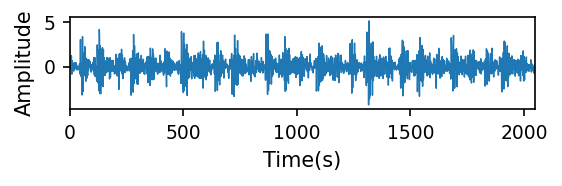

In [5]:
def plot_signal(x, t=None, figsize=(4,0.8),tit=None,xlb='Time(s)',ylb='Amplitude',
                axis_off=False, sp=None):
    plt.figure(figsize=figsize )
    if t is not None:
        plt.plot( t, x, linewidth=0.7 )
        plt.xlim(t[0],t[-1])
    else:
        plt.plot( x, linewidth=0.7 )
        plt.xlim( 0,  len(x)  )
    
    if xlb is not None: plt.xlabel(xlb )
    if ylb is not None: plt.ylabel(ylb )
    if tit is not None: plt.title( tit )
    if axis_off:          plt.axis('off')
    if sp  is not None: 
        plt.savefig(sp + tit + '.png', bbox_inches ='tight')
        plt.savefig(sp + tit + '.svg', bbox_inches ='tight')
    plt.show()
    return

def show_matrix(x, figsize=(3,1),tit=None,xlb=None,ylb=None,axis_off=False,need_colorbar=False,sp=None):
    plt.figure(figsize=figsize )
    plt.contourf( x, levels=16, cmap=None)
    
    if xlb is not None: plt.xlabel(xlb )
    if ylb is not None: plt.ylabel(ylb )
    if tit is not None: plt.title( tit )
    if need_colorbar:     plt.colorbar(shrink =0.99)
    if axis_off:          plt.axis('off')
    if sp  is not None: 
        plt.savefig(sp + tit + '.png', bbox_inches ='tight')
        plt.savefig(sp + tit + '.svg', bbox_inches ='tight')
    plt.show()
    return

def show_attention(x, figsize=(3,1),tit=None,xlb='Position',ylb='Attention',axis_off=False, need_colorbar=False,sp=None):
    plt.figure(figsize=figsize )
    plt.contourf( x, levels=4, cmap='inferno')
    
    if xlb is not None: plt.xlabel(xlb )
    if ylb is not None: plt.ylabel(ylb )
    if tit is not None: plt.title( tit )
    if need_colorbar:     plt.colorbar(shrink =0.99)
    if axis_off:          plt.axis('off')
    if sp  is not None: 
        plt.savefig(sp + tit + '.png', bbox_inches ='tight')
        plt.savefig(sp + tit + '.svg', bbox_inches ='tight')
    plt.show()
    return

# temp_cwt = np.arange(256*64).reshape(64,256)
# show_matrix(temp_cwt, tit='temp_CWT-without-tf', axis_off=False,  need_colorbar=True,sp='./save/')

# show_attention(temp_cwt, tit='temp_CWT-without-tf', axis_off=False,  need_colorbar=True,sp='./save/')

def plot_qk_curves(q,k, figsize=(3,1),tit=None,xlb='Position',ylb='Attention',axis_off=False, sp=None):
    plt.figure(figsize=figsize )
    plt.plot( q,label='Query' )
    plt.plot( k,label='Key' )
    plt.legend()
    plt.xlim(0,len(q))
    
    if xlb is not None: plt.xlabel(xlb )
    if ylb is not None: plt.ylabel(ylb )
    if tit is not None: plt.title( tit )
    if axis_off:          plt.axis('off')
    if sp  is not None: 
        plt.savefig(sp + tit + '.png', bbox_inches ='tight')
        plt.savefig(sp + tit + '.svg', bbox_inches ='tight')
    plt.show()
    return

# x = np.arange(100)
# y = np.arange(100)*2
# plot_qk_curves(x,y, tit='qk' , axis_off=False,  sp='./save/')

plot_signal(sig_data[4])

# get_tra_tes_ds

In [6]:
traXs,tesXs,  traYs,tesYs = train_test_split(temp_data, temp_labels,   test_size=0.20, shuffle=True, random_state=19960103 )

# 22-9-5
def get_tra_tes_ds(traXs,tesXs,  traYs,tesYs, BS=BATCH_SIZE,  is_train=False):
    [traXs,tesXs,  traYs,tesYs] = [np.array( item ) for item in [traXs,tesXs,  traYs,tesYs]] # list格式转成np.array好索引
    print('traXs.shape,  traYs.shape, traYs[:10]\t',traXs.shape,  traYs.shape, traYs[:10],sep='\t')
    print('tesXs.shape,  tesYs.shape, tesYs[:10]\t',tesXs.shape,  tesYs.shape, tesYs[:10],sep='\t')
    tra_ds = tf.data.Dataset.from_tensor_slices((traXs,traYs)).repeat().shuffle(len(traXs)).batch(BS, drop_remainder=True).prefetch(2)
    tes_ds = tf.data.Dataset.from_tensor_slices((tesXs,tesYs)).repeat().shuffle(len(traXs)).batch(BS).prefetch(2)
    return tra_ds, tes_ds

tra_ds, tes_ds = get_tra_tes_ds(traXs,tesXs,  traYs,tesYs)

tra_bX, tra_bY = next(iter(tra_ds))
print('tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10]',tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10] ,sep='\t')

tes_bX, tes_bY = next(iter(tes_ds))
print('tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10]',tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10],sep='\t')


traXs.shape,  traYs.shape, traYs[:10]		(4000, 6144, 1)	(4000,)	[7 0 4 3 9 9 0 7 9 8]
tesXs.shape,  tesYs.shape, tesYs[:10]		(1000, 6144, 1)	(1000,)	[1 9 5 9 8 8 0 0 3 7]


2024-04-12 20:18:00.554796: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 20:18:00.555181: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-12 20:18:00.555389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-12 20:18:00.556089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.645GHz coreCount: 16 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 238.66G

tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10]	(64, 6144, 1)	(64,)	[9 5 6 3 7 2 0 9 0 4]
tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10]	(64, 6144, 1)	(64,)	[7 7 9 7 2 4 9 3 1 1]


# 加载数据

## get_batch_from_path

In [7]:
def get_batch_from_path(set_flag='BJUT_18mN', file_type='csv', strides=5, # STRIDES为5时，每类有100样本
                        train_rate=0.2, seed = 19960103):
    '''本项目里面，数据加载的最高级封装，
    依据数据集的名字和工况加载对应数据，
    CWRU：加载对应工况下，正常 + 3程度*3故障类别/程度 的 10 类数据
    B02022：加载对应工况下，正常 + 2程度*3故障类别/程度 的 7 类数据
    加载好的数据，需要返回划分好的traXs,traYs, tesXs,tesYs
    以及，tra_ds, tes_ds
    '''
    assert set_flag in FOLDER_LIST
    
    
    # 加载数据
    all_Xs, all_Ys = load_data( folder=set_flag, file_type=file_type, strides=strides  )
    if 'BJUT' in set_flag:
        CLS_NUM = 7
    if 'CWRU' in set_flag:
        CLS_NUM =  10
    print('CLS_NUM = ', CLS_NUM)
        
    traXs,tesXs,  traYs,tesYs = train_test_split(all_Xs, all_Ys,   test_size=1-train_rate, 
                                                 shuffle=True, random_state= seed,
                                                stratify=all_Ys
                                                )
    print('Train number = {0:5d}, Test number = {1:5d}'.format(len(traXs),  len(tesXs)))
    print(Counter(traYs),Counter(tesYs), sum(tesYs)/sum(traYs))
    
    tra_ds, tes_ds = get_tra_tes_ds(traXs,tesXs,  traYs,tesYs)

    tra_bX, tra_bY = next(iter(tra_ds))
    print('tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10]',tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10] ,sep='\t')

    tes_bX, tes_bY = next(iter(tes_ds))
    print('tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10]',tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10],sep='\t')
    print('Dataset OK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n\n')
    
    return (traXs,tesXs,  traYs,tesYs), (tra_ds, tes_ds), CLS_NUM


(traXs,tesXs,  traYs,tesYs), (tra_ds, tes_ds), CLS_NUM = get_batch_from_path( set_flag = 'CWRU_0HP')

['../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_01]____[IDX_000969].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_02]____[IDX_001210].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_01]____[IDX_000890].csv'
 ...
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_07]____[IDX_003810].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_05]____[IDX_002559].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_04]____[IDX_002245].csv']
1111111111111111111111111111
[1 6 1 0 8 2 6 9 2 6 8 3 8 7 8 6 6 7 6 5 5 7 2 2 4 1 0 9 4 9 1 7 6 1 7 5 7
 6 0 0 2 4 5 0 8 4 0 0 6 9 1 5 3 1 5 3 2 0 4 4 4 8 8 3 0 2 6 7 0 3 0 5 5 8
 1 4 3 9 3 6 1 1 0 8 1 8 5 1 8 3 6 3 8 9 2 7 3 6 0 9 2 2 0 1 5 9 4 4 4 8 2
 1 8 9 6 7 2 4 1 2 2 7 1 1 5 3 7 9 3 2 2 4 2 3 6 0 2 5 0 6 8 7 9 5 8 0 6 7
 3 5 8 5 1 3 8 4 1 8 2 0 9 2 8 7 2 0 8 3 8 8 9 0 8 7 8 0 1 0 6 6 3 0 4 6 4
 9 3 8 1 6 5 4 6 6 5 0 1 4 0 3 0 9 6 6 9 8 7 0 9 9 0 6 1 9 0 6 1 4 3 2 6 0
 4 2 4 3 8 3 6 2 6 6 7 8 1 6 1 7 2 7 6 9 3 4 8 7 0 2 8 2 1 6 5 1 

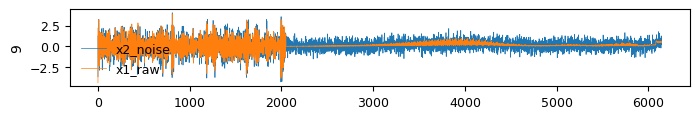

0 (64, 6144, 1) (64, 6144, 1) (64,)


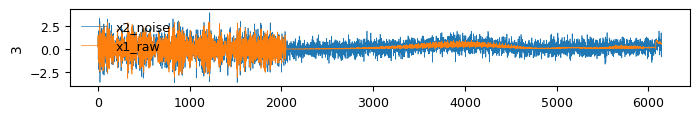

1 (64, 6144, 1) (64, 6144, 1) (64,)


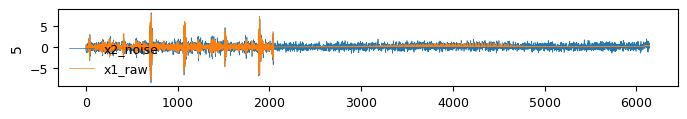

2 (64, 6144, 1) (64, 6144, 1) (64,)


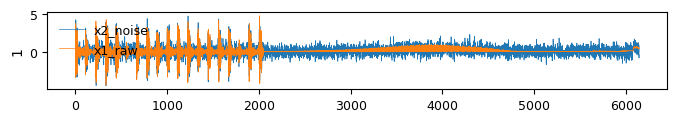

3 (64, 6144, 1) (64, 6144, 1) (64,)


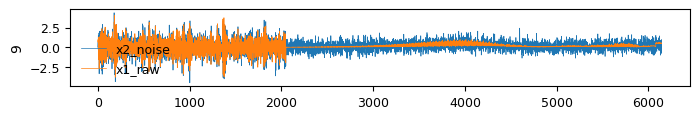

4 (64, 6144, 1) (64, 6144, 1) (64,)


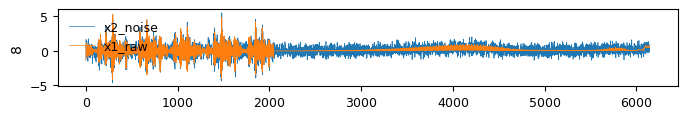

5 (64, 6144, 1) (64, 6144, 1) (64,)


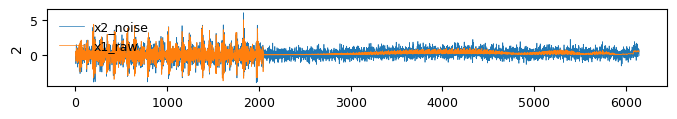

6 (64, 6144, 1) (64, 6144, 1) (64,)


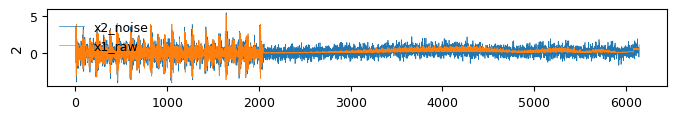

7 (64, 6144, 1) (64, 6144, 1) (64,)


In [8]:
for i,(bx,by) in enumerate(tra_ds.take(8)):
    
    noise = np.random.normal(loc=0.0, scale=0.50, size=bx.shape)
    
    x1 = bx[0].numpy()
    
    bx2 = bx + noise
    x2 = bx2[0].numpy()
    
    plt.figure(figsize=(8,1),dpi=100)
    plt.plot(x2, label='x2_noise', linewidth=0.5)
    plt.plot(x1, label='x1_raw', linewidth=0.5)
    
#     plt.xlim(0,1000)
    plt.legend()
    plt.ylabel(by[0].numpy())
    plt.show()
    print(i,bx.shape, noise.shape, by.shape)
    
    

# 构建模型
##   MLP + BiLSTM + CNN + ResNet

In [9]:
from functions.models_building import get_CNN, get_ResNet, get_HCM, get_MLP, get_BiLSTM

CWT_SHAPE = (64,64)
SIG_SHAPE = (2048,1)
# MLP = get_MLP(input_shape = SIG_SHAPE )
# # print( MLP.summary() )
# print('MLP', MLP.input_shape, MLP.output_shape , MLP.count_params())

# LSTM = get_BiLSTM(input_shape = SIG_SHAPE)
# # print( LSTM.summary() )
# print('LSTM', LSTM.input_shape, LSTM.output_shape , LSTM.count_params())

# CNN = get_CNN(input_shape = SIG_SHAPE)
# # print( CNN.summary() )
# print('CNN', CNN.input_shape, CNN.output_shape, CNN.count_params())


# ResNet = get_ResNet(input_shape = SIG_SHAPE)
# # print( ResNet.summary()  )
# print('Res', ResNet.input_shape, ResNet.output_shape , ResNet.count_params())

## Transformer

In [10]:
import tensorflow as tf
# from functions.AET_model_building import get_ST,get_NET,get_AET
from functions.AET_models import get_ST,get_NET,get_AET
import numpy as np

x = np.ones(shape=(7,2048,1))
st = get_ST(num_layers=3, need_show=True)

st(x).shape, st.count_params()

2.4.1

                  # 输入 2D信号 的参数
                  cwt_data                	 = 	 False,
                  cwt_shape               	 = 	 (256, 64),
                  cwt_patch               	 = 	 (8, 8),
                  cwt_embedding_way       	 = 	 Linear,
                  
                  # 输入 1D信号 的参数
                  sig_data                	 = 	 True,
                  sig_shape               	 = 	 (2048, 1),
                  sig_patch               	 = 	 (32,),
                  sig_embedding_way       	 = 	 Linear,
    
                  # Transformer的参数
                  positional_encoding_way 	 = 	 trainable,
                  num_layers              	 = 	 3,
                  cls_token               	 = 	 True,
                  
                  # Encoder_Layer 的参数
                  d_model                 	 = 	 64,
                  num_heads               	 = 	 4,
                  rate                    	 = 	 0.1,  
                  
                  cwt_

2024-04-12 20:18:31.889856: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-04-12 20:18:32.519340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(TensorShape([7, 64]), 106880)

In [11]:
net = get_NET(num_layers=3, need_show=True)
net(x).shape, net.count_params()


                  # 输入 2D信号 的参数
                  cwt_data                	 = 	 False,
                  cwt_shape               	 = 	 (256, 64),
                  cwt_patch               	 = 	 (8, 8),
                  cwt_embedding_way       	 = 	 Linear,
                  
                  # 输入 1D信号 的参数
                  sig_data                	 = 	 True,
                  sig_shape               	 = 	 (2048, 1),
                  sig_patch               	 = 	 (32,),
                  sig_embedding_way       	 = 	 NonLinear,
    
                  # Transformer的参数
                  positional_encoding_way 	 = 	 trainable,
                  num_layers              	 = 	 3,
                  cls_token               	 = 	 True,
                  
                  # Encoder_Layer 的参数
                  d_model                 	 = 	 64,
                  num_heads               	 = 	 4,
                  rate                    	 = 	 0.1,  
                  
                  cwt_pos

(TensorShape([7, 64]), 126208)

In [12]:
aet = get_AET(num_layers=3, need_show=True)
aet(x)[0].shape,aet(x)[1].shape, aet.count_params()


                  # 输入 2D信号 的参数
                  cwt_data                	 = 	 False,
                  cwt_shape               	 = 	 (256, 64),
                  cwt_patch               	 = 	 (8, 8),
                  cwt_embedding_way       	 = 	 Linear,
                  
                  # 输入 1D信号 的参数
                  sig_data                	 = 	 True,
                  sig_shape               	 = 	 (2048, 1),
                  sig_patch               	 = 	 (32,),
                  sig_embedding_way       	 = 	 AutoEncoder,
    
                  # Transformer的参数
                  positional_encoding_way 	 = 	 trainable,
                  num_layers              	 = 	 3,
                  cls_token               	 = 	 True,
                  
                  # Encoder_Layer 的参数
                  d_model                 	 = 	 64,
                  num_heads               	 = 	 4,
                  rate                    	 = 	 0.1,  
                  
                  cwt_p

(TensorShape([7, 2048, 1]), TensorShape([7, 64]), 157825)

## get_model

In [13]:
# 22-10-12: 都是 1D 信号，ST的一步下采样为线性32，NET多步下采样为非线性32，AET多步下采样为非线性32,并自监督学习
CLS_NUM =  10
def get_model(  FEM_name,   CLS_NUM, num_layers=6  ):
    print('''GGGGGGGGGGGGGGGet Modellllllllllll \n FEM_name={},   CLS_NUM={},  need_BA={}
    '''.format(  FEM_name,   CLS_NUM,  None)  )
    assert FEM_name in ['MLP', 'BiLSTM',   'CNN','ResNet',   'ST','NET','AET'  ]
    shape1 = (SIGNAL_LENGTH,1)
    shape2 = (IMG_WIDTH, IMG_HEIGHT)
    
    '''特征提取器模型：FEM ''' 
    if FEM_name == 'MLP':
        FEM = get_MLP(input_shape = shape1 )
        feature_dim = FEM.output_shape[-1]
    if FEM_name == 'BiLSTM':
        FEM = get_BiLSTM(input_shape = shape1 )
        feature_dim = FEM.output_shape[-1]
    if FEM_name == 'CNN':
        FEM = get_CNN(input_shape = shape1 )
        feature_dim = FEM.output_shape[-1]
    if FEM_name == 'ResNet':
        FEM = get_ResNet(input_shape =shape1 )
        feature_dim = FEM.output_shape[-1]
    
        
    if FEM_name == 'ST':
        FEM =   get_ST(num_layers=num_layers, need_show=True)
        feature_dim = FEM.out_shape[-1]
    if FEM_name == 'NET':
        FEM =   get_NET(num_layers=num_layers, need_show=True)
        feature_dim = FEM.out_shape[-1]
    if FEM_name == 'AET':
        FEM =   get_AET(num_layers=num_layers, need_show=True)
        feature_dim = FEM.out_shape[-1]
    print('basic FEM  is ',FEM.name, '\t feature_dim = ',feature_dim  )
    

    '''健康分类器模型：Health classifier model'''
    HCM  =  get_HCM(dim_in = feature_dim, dim_out = CLS_NUM)

    return FEM, HCM


temp_models = get_model(  FEM_name = 'AET',  CLS_NUM  = CLS_NUM,  )
temp_FEM, temp_HCM = temp_models
temp_inputs = np.ones((7,2048,1))

temp_FEM_out = temp_FEM(temp_inputs, training=True)
print( 'temp_FEM_out[0].shape ',    temp_FEM_out[0].shape  )
print( 'temp_FEM_out[1].shape ',    temp_FEM_out[1].shape  )

print( 'temp_HCM.input_shape ',  temp_HCM.input_shape  )
temp_FEM.count_params()

GGGGGGGGGGGGGGGet Modellllllllllll 
 FEM_name=AET,   CLS_NUM=10,  need_BA=None
    

                  # 输入 2D信号 的参数
                  cwt_data                	 = 	 False,
                  cwt_shape               	 = 	 (256, 64),
                  cwt_patch               	 = 	 (8, 8),
                  cwt_embedding_way       	 = 	 Linear,
                  
                  # 输入 1D信号 的参数
                  sig_data                	 = 	 True,
                  sig_shape               	 = 	 (2048, 1),
                  sig_patch               	 = 	 (32,),
                  sig_embedding_way       	 = 	 AutoEncoder,
    
                  # Transformer的参数
                  positional_encoding_way 	 = 	 trainable,
                  num_layers              	 = 	 6,
                  cls_token               	 = 	 True,
                  
                  # Encoder_Layer 的参数
                  d_model                 	 = 	 64,
                  num_heads               	 = 	 4,
             

258241

# Optimizer, Loss and Metrics

In [14]:
import tensorflow as tf

def get_macro_F1(y_true, y_pred, cls_num):
    '''多分类的Macro F1 的计算，
    在这里，y_true是真实标签，y_pred是预测标签。
    注意：y_true, y_true均是普通数字标签而不是onehot格式
    （如若有3类的话，为【0，1，2】，不是【【1，0，0】，【0，1，0】，【0，0，1】】）
    '''
    y_true = tf.cast(y_true, dtype=tf.int32)
    y_pred = tf.cast(y_pred, dtype=tf.int32)
    
    # calculate per-class precision, recall, and F1
    precisions = []
    recalls = []
    f1s = []

    # loop over each class
    for class_idx in range(cls_num):
        # convert y_true and y_pred to binary arrays for the current class
        class_true = tf.equal(y_true, class_idx)
        class_pred = tf.equal(y_pred, class_idx)

        # count true positive, false positive, and false negative for the class
        true_positives  = tf.reduce_sum(tf.cast(tf.math.logical_and(class_true, class_pred), tf.int32))
        false_positives = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(class_true), class_pred), tf.int32))
        false_negatives = tf.reduce_sum(tf.cast(tf.math.logical_and(class_true, tf.math.logical_not(class_pred)), tf.int32))

        # calculate precision, recall, and F1 for the class
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    
#     print([i.numpy() for i in f1s])
    # calculate macro-average F1 score
    macro_precisions = tf.reduce_mean(precisions)*100
    macro_recalls = tf.reduce_mean(recalls)*100
    macro_f1s = tf.reduce_mean(f1s)*100
    return macro_f1s, macro_precisions, macro_recalls


y_true  = [0, 1, 2, 0, 1, 2]
y_pred  = [0, 1, 2, 0, 0, 1]

# count number of classes
cls_num = 3

macro_f1s, macro_precisions, macro_recalls = get_macro_F1(y_true, y_pred, cls_num)
macro_f1s, macro_precisions, macro_recalls


(<tf.Tensor: shape=(), dtype=float64, numpy=65.55555555555556>,
 <tf.Tensor: shape=(), dtype=float64, numpy=72.22222222222221>,
 <tf.Tensor: shape=(), dtype=float64, numpy=66.66666666666666>)

In [15]:
'''这里定义的LOSS和METRIC都是全局变量，
尤其是 METRIC ，每次需要从零开始时需要 reset_metrics
'''
optimizer  = tf.keras.optimizers.Adam( 0.0005 )

metric_name_list = ['CE', 'MSE', 'Acc(%)', 'F1(%)', 'P(%)', 'R(%)']

# 交叉熵损失函数用来是衡量 预测误差
CE_loss  = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
MSE_loss = tf.keras.losses.MeanSquaredError( )

# train_step 中 loss 在求梯度时已经算过了，所以只需要把求得的loss记录即可, 但 acc 需要单独计算
train_CE_metric  = tf.keras.metrics.Mean( name='train_CE_metric')  
train_MSE_metric = tf.keras.metrics.Mean( name='train_MSE_metric')  
train_ACC_metric = tf.keras.metrics.SparseCategoricalAccuracy(     name='train_ACC_metric') 
train_F1_metric  = tf.keras.metrics.Mean( name='train_F1_metric')  
train_P_metric   = tf.keras.metrics.Mean( name='train_P_metric')  
train_R_metric   = tf.keras.metrics.Mean( name='train_R_metric')  


# test_step 中， 需要 单独计算 loss 和 acc
test_CE_metric   = tf.keras.metrics.Mean( name='test_CE_metric')
test_MSE_metric  = tf.keras.metrics.Mean( name='test_MSE_metric')  
test_ACC_metric  = tf.keras.metrics.SparseCategoricalAccuracy(     name='test_ACC_metric')
test_F1_metric   = tf.keras.metrics.Mean( name='test_F1_metric')  
test_P_metric    = tf.keras.metrics.Mean( name='test_P_metric')  
test_R_metric    = tf.keras.metrics.Mean( name='test_R_metric')

#  train metrics
def reset_train_metrics():
    train_CE_metric.reset_states()    # 训练 健康分类器的交叉熵
    train_MSE_metric.reset_states()   # 训练 自编码器的MSE
    train_ACC_metric.reset_states()   # 训练 健康分类器的准确率
    train_F1_metric.reset_states()    # 训练 健康分类器的 F1
    train_P_metric.reset_states()     # 训练 健康分类器的 P
    train_R_metric.reset_states()     # 训练 健康分类器的 R
    
def get_train_metrics_result():
    CE   = train_CE_metric.result().numpy()
    MSE  = train_MSE_metric.result().numpy()
    ACC  = train_ACC_metric.result().numpy()*100
    F1   = train_F1_metric.result().numpy()
    Pr   = train_P_metric.result().numpy()
    Re   = train_R_metric.result().numpy()
    return [CE,MSE,ACC,F1,Pr,Re]

#  test metrics
def reset_test_metrics():
    test_CE_metric.reset_states()     # 测试 健康分类器的交叉熵
    test_MSE_metric.reset_states()    # 测试 自编码器的MSE
    test_ACC_metric.reset_states()    # 测试 健康分类器的准确率
    test_F1_metric.reset_states()     # 测试 健康分类器的 F1
    test_P_metric.reset_states()      # 测试 健康分类器的 P
    test_R_metric.reset_states()      # 测试 健康分类器的 R
    
def get_test_metrics_result():
    CE  = test_CE_metric.result().numpy()
    MSE = test_MSE_metric.result().numpy()
    ACC = test_ACC_metric.result().numpy()*100
    F1  = test_F1_metric.result().numpy()
    Pr   = test_P_metric.result().numpy()
    Re   = test_R_metric.result().numpy()
    return [CE,MSE,ACC,F1,Pr,Re]

# train_step and test_step

In [16]:
'''2023-2-6
一个  tf.GradientTape()  监督多个子模型的可训练变量，
模型里面的每个张量，都是以列表的格式存储，
因此两个模型的张量梯度列表可以串联起来，
然后，对合起来的张量列表里的每个张量求一次梯度，
得到每个张量的梯度列表，
最后 根据梯度列表，给每个张量更新参数
'''

def train_step(X, Y, models, w_ce=1.0, w_mse=0.0):
    #print('X.shape, Y.shape',    X.shape, Y.shape, )
    FEM, HCM = models
    noise = np.random.normal(loc=0.0, scale=0.5, size=X.shape)
    X = X + noise
    with tf.GradientTape() as tape:
        if FEM.name=='AET': 
            XRC,F = FEM( X, training = True)
            P   = HCM( F, training = True)
            # print('X.shape, Y.shape, F.shape, P.shape',X.shape, Y.shape, F.shape, P.shape  )
            ce  = CE_loss(y_true=Y, y_pred=P )
            mse = MSE_loss(y_true=X, y_pred=XRC)
            loss = w_ce*ce + w_mse*mse
            
        else:
            F   = FEM( X, training = True)                    # 提取的 特征          (bs, dim)
            P   = HCM( F, training = True)                    # 预测 健康状态        (bs, 10)  
            ce  = CE_loss(y_true=Y, y_pred=P )
            mse = 0.0
            loss = ce
    
    trainable_variables = FEM.trainable_variables + HCM.trainable_variables
    # FEM.trainable_variables 以列表的形式存储模型里的每个可训练参数
    gradients  = tape.gradient( loss,          trainable_variables)
    optimizer.apply_gradients(zip(gradients,   trainable_variables))
    
    P_argmax = tf.argmax( P, axis=-1)
    cls_num  = tf.shape( P )[-1]
    F1,Pr,Re = get_macro_F1(y_true=Y, y_pred=P_argmax, cls_num=cls_num)
    
    train_CE_metric.update_state( ce )
    train_MSE_metric.update_state( mse )
    train_ACC_metric.update_state( y_true=Y, y_pred=P  )
    train_F1_metric.update_state( F1 )
    train_P_metric.update_state( Pr )
    train_R_metric.update_state( Re )
    return (FEM, HCM)


def test_step(X, Y, models):
    FEM, HCM = models
    
    if FEM.name=='AET': 
        XRC,F = FEM( X, training = False)
        P   = HCM( F, training = False)
        # print('X.shape, Y.shape, F.shape, P.shape',X.shape, Y.shape, F.shape, P.shape  )
        ce  = CE_loss(y_true=Y, y_pred=P )
        mse = MSE_loss(y_true=X, y_pred=XRC)

    else:
        F   = FEM( X, training = False)                    # 提取的 特征          (bs, dim)
        P   = HCM( F, training = False)                    # 预测 健康状态        (bs, 10)  
        ce  = CE_loss(y_true=Y, y_pred=P )
        mse = 0.0
    
    P_argmax = tf.argmax( P, axis=-1)
    cls_num  = tf.shape( P )[-1]
    F1,Pr,Re = get_macro_F1(y_true=Y, y_pred=P_argmax, cls_num=cls_num)
    
    test_CE_metric.update_state(  ce )
    test_MSE_metric.update_state( mse )
    test_ACC_metric.update_state( y_true=Y, y_pred=P )
    test_F1_metric.update_state( F1 )
    test_P_metric.update_state( Pr )
    test_R_metric.update_state( Re )
    return

(traXs,tesXs,  traYs,tesYs), (tra_ds, tes_ds), CLS_NUM = get_batch_from_path( set_flag = 'CWRU_0HP',  file_type='csv', strides=10)
temp_models = get_model(      FEM_name='AET',   CLS_NUM=CLS_NUM,    )

bX, bY = next(iter(tra_ds))
bX=bX[:, :2048, :]

train_step(  X = bX, Y = bY,  models=temp_models  )
test_step(   X = bX, Y = bY,  models=temp_models  )

def print_log(metric_results, need_show_metric_name=False, metric_names = metric_name_list, ):
    if need_show_metric_name:
        [print('{}'.format(i),      end='\t') for i in metric_names]
        print()
    [print('{:.2f}'.format(i),  end='\t') for i in metric_results]
    print()
    return

print_log(get_train_metrics_result(), True)
print_log(get_test_metrics_result(), False)

['../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_01]____[IDX_000969].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_02]____[IDX_001210].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_01]____[IDX_000890].csv'
 ...
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_07]____[IDX_003810].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_05]____[IDX_002559].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_04]____[IDX_002245].csv']
1111111111111111111111111111
[1 1 8 6 2 8 8 8 6 6 5 2 4 0 4 1 6 7 7 0 2 5 8 0 6 1 3 5 2 4 4 8 0 6 0 0 5
 1 3 3 1 0 1 5 8 6 8 2 3 0 2 0 5 4 4 2 8 6 2 1 2 1 5 7 3 2 2 6 2 0 8 9 8 6
 3 8 1 8 1 2 9 8 2 8 8 9 8 8 1 6 3 4 4 3 1 5 6 5 1 0 0 6 9 7 9 0 1 0 1 3 6
 4 4 8 6 6 7 1 1 2 6 3 8 0 8 1 5 6 5 0 3 2 6 7 6 4 8 2 2 2 1 1 8 1 8 5 6 9
 6 3 9 7 4 4 0 5 9 7 9 7 0 3 5 2 4 4 7 6 1 4 7 3 8 0 6 5 1 7 5 3 3 5 2 5 6
 0 9 5 7 7 4 6 2 4 5 3 1 0 4 6 8 0 8 2 4 0 3 4 1 2 4 3 4 8 5 4 4 5 3 8 3 4
 3 8 0 2 0 4 2 6 0 3 5 2 0 3 7 4 2 1 0 4 1 8 3 5 8 6 1 7 4 6 7 5 

# train_model

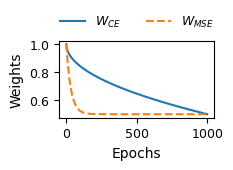

In [17]:
# epoch 等设置为全局变量，就不用每次都传参了
epochs     = np.arange(1000)
weight_ce  = 1-0.5*np.sqrt(epochs/1000)
weight_mse = 0.5 + 0.5*np.exp(-epochs/32)

plt.figure(figsize=(2,1),dpi=100)
plt.plot(epochs, weight_ce, '-',  label='$W_{CE}$')
plt.plot(epochs, weight_mse, '--', label='$W_{MSE}$')
plt.legend(ncol=2, loc='lower center',    bbox_to_anchor=(0.50, 1.0),)
plt.xlabel('Epochs')
plt.ylabel('Weights')
plt.savefig('weights.png',dpi=600,bbox_inches='tight')

In [ ]:
weight_ce.shape

In [18]:
def train_model(tra_ds, tes_ds, models, epoch_num=100,
                steps_per_epoch=10, val_steps_per_epoch=1, info=None ): 
    '''从随机初始化的模型开始训练，直到模型收敛'''
    train_model_start_time = time.time()
    print('train_model 开始了','!'*100)
    tra_ds_iter, tes_ds_iter = iter( tra_ds ), iter( tes_ds )
    
    assert epoch_num <= len(weight_ce)
    
    tra_tes_metric_logs = []
    for epoch in range(epoch_num):
        epoch_start_time = time.time()
        reset_train_metrics() # 重置多个metric的观测器
        reset_test_metrics()  # 重置多个metric的观测器

        '''---------Training------------------'''
        for step in range(steps_per_epoch):
            bX,bY = next(tra_ds_iter)
            bX=bX[:, :2048, :]
            models = train_step(X=bX, Y=bY, 
                                models=models,
                                w_ce=weight_ce[epoch],
                                w_mse=weight_mse[epoch])

        '''----------Testing-------------------'''
        for step in range(val_steps_per_epoch):
            bX,bY = next(tes_ds_iter)
            bX=bX[:, :2048, :]
            test_step(X=bX, Y=bY, models=models)  # 对验证集的测试
            
            
        '''----------Metrics-------------------'''    
        tra_metrics = get_train_metrics_result()
        tes_metrics = get_test_metrics_result()
        tra_tes_metric_logs.append( tra_metrics + tes_metrics )
        
        '''----------Print-------------------'''    
        if epoch%10==0 or epoch+1==epoch_num:
#         if epoch%q==0 :
            cinfo = '\t traN={}, \ttesN={}, \t w_ce={:.2f}, \t w_mse={:.2f}'.format(
                steps_per_epoch,val_steps_per_epoch,weight_ce[epoch], weight_mse[epoch])
            if info is not None: print(info, cinfo)
            print_log(tra_metrics, True)
            print_log(tes_metrics, False)
            print('Epoch:{:4d}, \t\t Epoch time: {:>8.2f}\n'.format(epoch,     time.time()-epoch_start_time ))
       
    tra_tes_metric_logs = np.array( tra_tes_metric_logs )  # [max_epoch,  4]
    print('Train_model time: {:>8.2f}'.format(       time.time()-train_model_start_time )            )
    print('train_model 结束了','!'*100)
    return models, tra_tes_metric_logs

(traXs,tesXs,  traYs,tesYs), (tra_ds, tes_ds), CLS_NUM = get_batch_from_path(   set_flag = 'CWRU_0HP',  
                                                                                file_type='csv', 
                                                                                strides=5,
                                                                                train_rate=0.5,
                                                                                seed=19960103,)
temp_models = get_model(      FEM_name='AET',   CLS_NUM=CLS_NUM,    )

models, tra_tes_metric_logs = train_model(tra_ds, tes_ds, temp_models,  epoch_num=1000,
                steps_per_epoch=1, val_steps_per_epoch=1, info=None )

['../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_01]____[IDX_000969].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_02]____[IDX_001210].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_01]____[IDX_000890].csv'
 ...
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_07]____[IDX_003810].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_05]____[IDX_002559].csv'
 '../sample_data/CWRU_0HP/[CWRU]____[0HP]____[CLS_04]____[IDX_002245].csv']
1111111111111111111111111111
[1 6 1 0 8 2 6 9 2 6 8 3 8 7 8 6 6 7 6 5 5 7 2 2 4 1 0 9 4 9 1 7 6 1 7 5 7
 6 0 0 2 4 5 0 8 4 0 0 6 9 1 5 3 1 5 3 2 0 4 4 4 8 8 3 0 2 6 7 0 3 0 5 5 8
 1 4 3 9 3 6 1 1 0 8 1 8 5 1 8 3 6 3 8 9 2 7 3 6 0 9 2 2 0 1 5 9 4 4 4 8 2
 1 8 9 6 7 2 4 1 2 2 7 1 1 5 3 7 9 3 2 2 4 2 3 6 0 2 5 0 6 8 7 9 5 8 0 6 7
 3 5 8 5 1 3 8 4 1 8 2 0 9 2 8 7 2 0 8 3 8 8 9 0 8 7 8 0 1 0 6 6 3 0 4 6 4
 9 3 8 1 6 5 4 6 6 5 0 1 4 0 3 0 9 6 6 9 8 7 0 9 9 0 6 1 9 0 6 1 4 3 2 6 0
 4 2 4 3 8 3 6 2 6 6 7 8 1 6 1 7 2 7 6 9 3 4 8 7 0 2 8 2 1 6 5 1 

In [22]:
bX.shape

TensorShape([64, 6144, 1])

In [23]:
bX[:, :2048, :]

TensorShape([64, 2048, 1])

# 训练

## Weights、LOG、RESULT

In [37]:
def save_weights_and_log():
    FEM, HCM = models
    
    '''存储模型权重'''
    item = save_path + get_date() + dta_R_date
    for model in models:
        model_save_path = item + model.name +'.h5'
        model.save_weights(model_save_path)
        model.load_weights(model_save_path)
    
    '''训练日志'''
    metric_names = ['CE', 'MSE','Accuracy(%)', 'F1(%)', 'Precision(%)', 'Recall(%)']
    columns = ['tra ' + i for i in metric_names] + ['val ' + i for i in metric_names]
    
    log_df = pd.DataFrame(tra_tes_metric_logs, columns = columns)
    log_path = save_path + get_date() + dta_R_date + 'LOG.csv'
    log_df.to_csv(log_path, index=False)
    
    print('-'*100, '\n训练的最后10Epoch的平均Metrics.')
    print(log_df.iloc[-10:,].describe().loc[['mean','50%']])
    print('训练的最后10Epoch的平均Metrics.\n','-'*100)
    return log_df,log_path
    
try:
    log_df,log_path = save_weights_and_log()
except:
    print('error')
    
    
def save_test_result(item=''):
    '''最终的测试结果'''
    tra_CE = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)(  y_true=traYs, y_pred=traPs )
    tra_AC = tf.keras.metrics.SparseCategoricalAccuracy()(                       y_true=traYs, y_pred=traPs )*100
    traF1,traP,traR = get_macro_F1(y_true=traYs, y_pred=traPargM, cls_num=CLS_NUM )

    tes_CE = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)(  y_true=tesYs, y_pred=tesPs )
    tes_AC = tf.keras.metrics.SparseCategoricalAccuracy()(                       y_true=tesYs, y_pred=tesPs )*100
    tesF1,tesP,tesR = get_macro_F1(y_true=tesYs, y_pred=tesPargM, cls_num=CLS_NUM )

    final_result = [ [item.numpy() for item in [  tra_CE,  tra_AC,    traF1,    traP,    traR,
                                                   tes_CE,  tes_AC,    tesF1,    tesP,    tesR,   ]]]
    result_names =                             [  'tra CE', 'tra AC',  'tra F1', 'tra P', 'tra R',
                                                  'tes CE', 'tes AC',  'tes F1', 'tes P', 'tes R',  ]
    
    final_result_df = pd.DataFrame(  data = final_result,  columns = result_names  )
   
    path =  save_path + get_date() + dta_R_date + item +'Final_Result.csv'
    final_result_df.to_csv(path,  index=False)
    
    print('='*100, '\n在训练集和测试集上的最终测试结果.\n')
    print(final_result_df)
    print('在训练集和测试集上的最终测试结果.\n','='*100)
    
    return final_result_df

try:
    final_result_df = save_test_result()
except:
    print('error')


---------------------------------------------------------------------------------------------------- 
训练的最后10Epoch的平均Metrics.
        tra CE   tra MSE  tra Accuracy(%)  tra F1(%)  tra Precision(%)  \
mean  1.817211  1.154143         37.96875  32.692422         38.469841   
50%   1.867899  1.153421         39.06250  34.809961         40.387972   

      tra Recall(%)    val CE   val MSE  val Accuracy(%)  val F1(%)  \
mean      38.176659  1.476604  0.897830         57.03125  46.989649   
50%       38.833332  1.434944  0.901967         60.93750  50.447067   

      val Precision(%)  val Recall(%)  
mean         49.070139      54.965873  
50%          51.856060      57.013889  
训练的最后10Epoch的平均Metrics.
 ----------------------------------------------------------------------------------------------------
error


## Metrics curve

In [ ]:
def plot_metrics_curve(df, metrics,need_tra=True, need_save=True):
    '''画出n个metrics的曲线图，metrics必须是list
    metric_names = ['SHCE','SHAC',  'THCE','THAC',  'SSC','SDC',  'DCE','DAC','DCS']
    '''
    assert isinstance(metrics,list)
    assert len(metrics) in [1,2]
    if 'CE' in str(metrics): assert len(metrics)==1
    
    plt.subplots(figsize=[2,1.5],)
    colors = ['#FF9671','b','#008E9B','r',]
    for mi,metric in enumerate(metrics):
        if need_tra:
            plt.plot(df['tra ' + metric],label='Train' ,  linewidth=1, color=colors[mi*2+0], alpha=0.7)  # 训练曲线
        plt.plot(    df['val ' + metric],label='Test' ,   linewidth=1, color=colors[mi*2+1], alpha=1.0)  # 验证曲线
    
    if need_tra:
        plt.legend(ncol=2,
               loc='lower center',        
               bbox_to_anchor=(0.50, 1.02),              # legend的坐标原点与坐标原点的相对坐标
               )
    
    plt.grid(True, linestyle='--', which='major', color='grey', alpha=.2)
    plt.grid(True, linestyle='-.', which='major', color='grey', alpha=.5)

    
    if 'E' in str(metrics):
#         plt.yticks(ticks=np.arange(0, 2,    4)  )
        plt.xlabel(xlabel='Epochs' )
        plt.ylabel(ylabel=metrics[0] )
    else:
        plt.yticks(  np.arange(0, 105, 25))
        plt.xlabel(xlabel='Epochs' )
        plt.ylabel(ylabel=metrics[0] )
        
        
    if need_save:
        path = save_path + get_date() + dta_R_date + str(metrics)
        plt.savefig(path + '.png',  bbox_inches ='tight')
#         plt.savefig(path + '.svg',  bbox_inches ='tight')
    plt.show()
    return

try:
    plot_metrics_curve(df= log_df, metrics = ['CE'])
    plot_metrics_curve(df= log_df, metrics = ['MSE'])
    plot_metrics_curve(df= log_df, metrics = ['Accuracy(%)'])
    plot_metrics_curve(df= log_df, metrics = ['F1(%)'])
    plot_metrics_curve(df= log_df, metrics = ['Precision(%)'])
    plot_metrics_curve(df= log_df, metrics = ['Recall(%)'])
except:
    print('没数据')

## Feature、Logits、Attention weights

In [ ]:
def get_features_AW_and_P_of_one_batch(models, bXs ):
    '''直接把所有样本都送进FEM来提特征时，数据量太大会内存溢出,
    由于 AW 太占内存了，所以只存储 1 batch 的AW，并返回
    '''
    ''' 输入一个batch的数据，返回一个batch的features，AW，P
    Xs.shape=【bs，pos, depth】，'''
    assert len(bXs) <= 100  # 输入数据太多时，可能会内存不够
#     print(type(bXs), bXs.shape)
    FEM, HCM = models
        
    if FEM.name in ['ST', 'NET', 'AET']:
        bFs, bAWs = FEM( bXs,   training = False, need_w=True)
        if  FEM.name=='AET':
            bXRC,bFs = bFs
    else:
        bFs  = FEM( bXs,   training = False)                   # 提取的 特征          (bs, dim)
        bAWs = {'No Data': np.zeros((1))} # 用于占位
    
    bPs  = HCM( bFs,    training = False)                   # 预测 健康状态        (bs, 256，256，4)  feat6，feat7，out8
    #print(bFs.shape, bPs.shape, BAWs.keys())
    return bFs, bPs, bAWs

def get_whole_FP(models, Xs, bs=100, need_save=True):
    batch_num = int(np.ceil(len(Xs)/bs) )
    print('输入了{:4d}样本,\t 测试时每{:4d}个样本一个batch @ '.format(len(Xs), bs), batch_num)
    all_Fs = []
    all_Ps = []
    for i in range(batch_num):
        bXs = Xs[  i*bs   :   (i+1)*bs   ]
        bFs, bPs, bAWs =  get_features_AW_and_P_of_one_batch(models=models, bXs =bXs,   )
        all_Fs.append( bFs )
        all_Ps.append( bPs )
    print('Last batch:',bFs.shape, bPs.shape)
    all_Fs = tf.concat( all_Fs, axis=0 ).numpy()
    all_Ps = tf.concat( all_Ps, axis=0 ).numpy()
    all_P_after_arg_max  = tf.argmax(all_Ps, axis=-1).numpy()
    
    ### 保存成CSV
    if need_save:
        Fs_df_columns = ['f_{}'.format(i) for i in range(all_Fs.shape[-1])]
        Fs_df =  pd.DataFrame(  data = all_Fs, columns=Fs_df_columns   )
        path  =  save_path + get_date() + dta_R_date +'Features.csv'
        Fs_df.to_csv(path,  index=False)

        Ps_df_columns = ['p_{}'.format(i) for i in range(all_Ps.shape[-1])]
        Fs_df =  pd.DataFrame(  data = all_Ps, columns=Ps_df_columns   )
        path  =  save_path + get_date() + dta_R_date +'Logits.csv'
        Fs_df.to_csv(path,  index=False)
    
    
    return all_Fs, all_Ps, all_P_after_arg_max

(traXs,tesXs,  traYs,tesYs), (tra_ds, tes_ds), CLS_NUM = get_batch_from_path(   set_flag = 'CWRU_0HP',  
                                                                                file_type='csv', 
                                                                                strides=5,
                                                                                train_rate=0.2,
                                                                                seed=19960103,)

bX, bY = next(iter(tra_ds))
temp_models = get_model(  FEM_name = 'AET',  CLS_NUM  = CLS_NUM,  )


bFs, bPs, bAWs =  get_features_AW_and_P_of_one_batch(models=temp_models, bXs = bX,  )
print(bFs.shape, bPs.shape, bAWs.keys())


traFs,  traPs,  traPargM  =  get_whole_FP( models=temp_models, Xs = traXs, need_save=False  )
tesFs,  tesPs,  tesPargM  =  get_whole_FP( models=temp_models, Xs = tesXs, need_save=True  ) # 仅保存测试集上的结果

print('traFs.shape, traPs.shape, traPargM.shape', traFs.shape, traPs.shape, traPargM.shape  )
print('tesFs.shape, tesPs.shape, traPargM.shape', tesFs.shape, tesPs.shape, traPargM.shape  )

## Confusion matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_num, item=None,  need_save=True):
    print('plot_confusion_matrix 入口： \t', y_true.shape, y_pred.shape )
    assert np.max(y_true)<class_num
    assert np.max(y_pred)<class_num
    
    cm = confusion_matrix(y_true, y_pred) 
#     print(cm)
    
    tick_names = Health_status
    tick_names = tick_names[:class_num]
    plt.figure(figsize=(3.,2.6) )
    sns.heatmap(
                    data = cm,
                    fmt  = '.0f',

                    annot=True,
                    annot_kws={'size': 9}, 
                    cmap='Blues',    # Greys  Blues Greens Reds

                    linewidths=0.1, 
                    linecolor='gray',
                )

    xlocations = np.array(range(class_num))+0.5
    plt.ylabel('True label' )
    plt.xlabel('Predicted label' )
    
    plt.xticks(ticks=np.arange(class_num)+0.5, labels=tick_names, rotation=0,)
    plt.yticks(ticks=np.arange(class_num)+0.5, labels=tick_names, rotation=0,)

    plt.gca().xaxis.set_ticks_position('none') # 屏蔽掉坐标轴的刻度线
    plt.gca().yaxis.set_ticks_position('none')
    if need_save:
        path = save_path + get_date() + dta_R_date + item +'Confusion_Matrix'
#         plt.savefig(path  + '.svg', bbox_inches ='tight')
        plt.savefig(path  + '.png', bbox_inches ='tight')
    plt.show()
    return

#print('-'*100, target_Y.shape, target_hc_label_P.shape, target_Y, target_hc_label_P)
plot_confusion_matrix(      y_true=traYs, 
                            y_pred=traPargM, 
                            class_num=CLS_NUM, 
                            item  =  'tra',  
                            need_save=True)

plot_confusion_matrix(      y_true=tesYs, 
                            y_pred=tesPargM, 
                            class_num=CLS_NUM, 
                            item  =  'tes',  
                            need_save=True)

## Features distribution

In [ ]:
from sklearn.manifold import TSNE

'''特征分布图'''
def plot_features_distribution(Fs, Ys,  item, class_num, need_save=True):
    X_tsne = TSNE(n_components=2,   
                  init = 'random',   # 'random', 'pca'  'warn'
                  random_state=19960103, 
                  learning_rate=100    ).fit_transform(Fs)
#     print(type(X_tsne), X_tsne.shape) #numpy.ndarray, [sample_number, n_components]

    plt.figure(figsize=(1.5,1.5))
    a, b = 0.9, 0.5
    c, d = '.', '+'

    color_list = ['#5B5B5B',     
                  'PINK',      'LIME',       'GOLD',     
                  'PURPLE',    'AQUA',       'NAVY',     
                  'TOMATO',    'SEAGREEN',   'BROWN']
    names = ['NC',
             'OF1','IF1','RF1',   
             'OF2','IF2','RF2',  
             'OF3','IF3','RF3']
    
    for i in range(class_num):
        current_components = X_tsne[Ys==i]
#         print(i, len(current_components) )
        cx = current_components[:, 0]
        cy = current_components[:, 1]
        # print(cx,cy)
        
        plt.scatter(    x      = cx,  
                        y      = cy, 
                        marker = c,                    
                        color  = color_list[i],    
                        label  = names[i],              
                        alpha  = a )

    plt.xticks([])
    plt.yticks([])
#     plt.xlabel('Componet 1')
#     plt.ylabel('Componet 2')
#     plt.legend(ncol=5,
#                loc='lower center',               # legend的坐标原点在右下角：4
#                bbox_to_anchor=(0.50, 1.02),      # legend的坐标原点与坐标原点的相对坐标
#                borderaxespad=0, 
#                handlelength =1,
# #                handletextpad=0.5
#               )
    plt.tight_layout()
    if need_save:
        path = save_path + get_date() + dta_R_date + item +'Feature_Distribution'
#         plt.savefig(path + '.svg',  bbox_inches ='tight')
        plt.savefig(path + '.png',  bbox_inches ='tight')
    plt.show()
    return

plot_features_distribution(Fs=traFs[::10], Ys=traYs[::10],  item='_tra_', class_num=CLS_NUM, need_save=True)
plot_features_distribution(Fs=tesFs[::10], Ys=tesYs[::10],  item='_tes_', class_num=CLS_NUM, need_save=True)


In [ ]:
tesXs.shape

In [ ]:
(traXs,tesXs,  traYs,tesYs), (tra_ds, tes_ds), CLS_NUM = get_batch_from_path(   set_flag = 'CWRU_0HP',  
                                                                                file_type='csv', 
                                                                                strides=5,
                                                                                train_rate=0.2,
                                                                                seed=77,)

print(traXs.shape,tesXs.shape)
plot_features_distribution(Fs=traXs[:,:,0], Ys=traYs,  item='_tra_rawsignal_', class_num=CLS_NUM, need_save=True)
plot_features_distribution(Fs=tesXs[:,:,0], Ys=tesYs,  item='_tes_rawsignal_', class_num=CLS_NUM, need_save=True)


## 训练过程

In [ ]:
[i/100 for i in [5,10,15,20,25]   ]

In [ ]:
WC_FLAG1_list = [0,]
# WC_FLAG2_list = [0,1,2,3]

STRIDES = 5


for tes_r in range(1):
    for TRAIN_RATE in [i/100 for i in [80]   ]:
        for FEM_NAME in  [ 'AET']: # 'MLP', 'BiLSTM',   'CNN','ResNet',   'ST','AET'
            for SET_FLAG in [ 'B2022'   ]:               # 'B2022', 'CWRU'  
                for WC_FLAG in WC_FLAG1_list:                #  [0,  1,  2,  3]
                    '''准备模型和数据的参数'''
                    real_set = BJUT_SET_NAME[WC_FLAG] if SET_FLAG=='B2022' else CWRU_SET_NAME[WC_FLAG]
                    current_train_model_info = '''
                    FEM  = {},\t  SET_FLAG={},\t WC_FLAG={},\t real_set={}, 
                    TesR = {},\t  TR = {},\t '''.format(
                        FEM_NAME, SET_FLAG,WC_FLAG,real_set, tes_r, TRAIN_RATE)
                    print(current_train_model_info)

                    '''准备数据'''
                    (traXs,tesXs,  traYs,tesYs), (tra_ds, tes_ds), CLS_NUM = get_batch_from_path( 
                            set_flag = real_set,  
                            strides=5,
                            train_rate = TRAIN_RATE,
                            seed = tes_r, )


                    '''每次完整的训练，都重置一下Model和OPT的参数'''
                    models = get_model( FEM_name=FEM_NAME,   CLS_NUM=CLS_NUM )

                    LEARNING_RATE = 0.001
                    optimizer  = tf.keras.optimizers.Adam(LEARNING_RATE )

                    '''训练，并返回训练好的 模型 and 训练日志 '''
                    models, tra_tes_metric_logs = train_model(tra_ds=tra_ds,
                                                              tes_ds=tes_ds,
                                                              models=models,
                                                              epoch_num=10,
                                                              steps_per_epoch=2, 
                                                              val_steps_per_epoch=1,
                                                              info = current_train_model_info,
                                                             )
                    
                    '''存储模型权重和训练日志'''                
                    dta_R_date = '______[' + FEM_NAME +  ']__[TRA_SET='+real_set+ ']__[TES_R'+str(tes_r) + ']__[TRAIN_RATE='+str(TRAIN_RATE) +']_____'
                    log_df,log_path = save_weights_and_log()

                    '''绘制训练曲线'''
                    log_df = pd.read_csv(  log_path  )
                    plot_metrics_curve(df=log_df, metrics=['CE'])
                    plot_metrics_curve(df=log_df, metrics=['MSE'])
                    plot_metrics_curve(df=log_df, metrics=['Accuracy(%)'])
                    plot_metrics_curve(df=log_df, metrics=['F1(%)'])
                    plot_metrics_curve(df=log_df, metrics=['Precision(%)'])
                    plot_metrics_curve(df=log_df, metrics=['Recall(%)'])

                    '''在训练数据集 和 测试数据集 上 测试模型最终的性能'''
                    traFs,  traPs,  traPargM = get_whole_FP(models=models, Xs=traXs, )
                    tesFs,  tesPs,  tesPargM = get_whole_FP(models=models, Xs=tesXs, )
                    print('traFs.shape, traPs.shape, traPargM.shape', traFs.shape, traPs.shape, traPargM.shape)
                    print('tesFs.shape, tesPs.shape, traPargM.shape', tesFs.shape, tesPs.shape, traPargM.shape)

                    item = '____[TraSET={0}-{1}]-[TesSET={2}-{3}]____'.format(SET_FLAG,WC_FLAG, SET_FLAG,WC_FLAG)
                    save_test_result(item = item)


                    '''绘制混淆矩阵'''
                    plot_confusion_matrix(y_true=traYs,
                                          y_pred=traPargM,
                                          class_num=CLS_NUM,
                                          item=item+'_TRA___',
                                          need_save=True)

                    plot_confusion_matrix(y_true=tesYs,
                                          y_pred=tesPargM,
                                          class_num=CLS_NUM,
                                          item=item+'_TES___',
                                          need_save=True)

                    '''绘制特征分布图'''
                    plot_features_distribution(  Fs=traFs, Ys=traYs,  item=item+'_TRA___', class_num=CLS_NUM, need_save=True)
                    plot_features_distribution(  Fs=tesFs, Ys=tesYs,  item=item+'_TES___', class_num=CLS_NUM, need_save=True)

                    print(current_train_model_info)
                    print('\nOne Epoch Done!!!\n', '#'*500, '\n\n\n\n\n\n\n\n\n\n\n\n\n')


# 结果分析

In [ ]:
traXs.shape, traYs.shape, tesXs.shape, tesYs.shape, traYs

In [ ]:
each_class_X = [traXs[traYs==i] for i in range(10)]
each_class_Y = [traYs[traYs==i] for i in range(10)]
each_class_N = [len(traYs[traYs==i]) for i in range(10)]

X = tf.concat(each_class_X, axis=0).numpy()
Y = tf.concat(each_class_Y, axis=0).numpy()
X.shape, Y[::80], each_class_N

In [ ]:
target_indexes = [72, 1*80+6, 2*80+56, 80*3+5, 80*4, 80*5+11, 80*6 ]
target_signals = X[target_indexes]
target_lables  = Y[target_indexes]

x_sine  = np.sin(np.linspace(0,150,2048)).reshape(-1,1)

################################################################
x_on    = np.stack([target_signals[1]]*10)
s = 650
k = 800
x_on[:5,s:s+k]    = np.random.normal(loc=0.0, scale=1.0, size=(5,k,1))
x_on[5:,]         += np.random.normal(loc=0.0, scale=1.0, size=(5,2048,1))

x_in    = np.stack([target_signals[2]]*10)
s = 650
k = 800
x_in[:5,s:s+k]    = np.random.normal(loc=0.0, scale=1.0, size=(5,k,1))
x_in[5:,]         += np.random.normal(loc=0.0, scale=1.0, size=(5,2048,1))
################################################################

simu_indexes = np.array(  [-1*i for i in range(1,21)])
simu_signals = np.concatenate([x_on, x_in])
simu_lables  = np.array( [-1,]*10+[-2,]*10)

target_indexes = np.concatenate([target_indexes, simu_indexes])
target_signals = np.concatenate([target_signals, simu_signals])
target_lables  = np.concatenate([target_lables,  simu_lables])

print( x_sine.shape, x_in.shape, target_signals.shape)

for i in range(len(target_indexes)):
    idx = target_indexes[i]
    x = target_signals[i]
    y = target_lables[i]
    
    plt.figure(figsize=(5,1))
    plt.plot(x,linewidth=0.5)
    plt.title('idx={},lb={}'.format(idx, y))
    plt.show()

In [ ]:
each_class_X = [traXs[traYs==i] for i in range(10)]
each_class_Y = [traYs[traYs==i] for i in range(10)]
each_class_N = [len(traYs[traYs==i]) for i in range(10)]

X = tf.concat(each_class_X, axis=0).numpy()
Y = tf.concat(each_class_Y, axis=0).numpy()
print(X.shape, Y[::80], each_class_N)

s = 650
k = 800

X_1, Y_1 = np.array(X),np.array(Y)
X_2, Y_2 = np.array(X),np.array(Y)

X_1[:,s:s+k]     = np.random.normal(loc=0.0, scale=1.0, size=(len(X),k,1))
X_2             += np.random.normal(loc=0.0, scale=1.0, size=(len(X),2048,1))

X = np.concatenate([X, X_1, X_2])
Y = np.concatenate([Y, Y_1, Y_2])
X.shape, Y[::80], Y.shape

In [ ]:
FEM, HCM = models
(xrc, feature), aw = FEM(each_class_X[0], training=False, need_w=True)
print([aw.shape for aw in list(aw.values())])
aww = tf.stack(list(aw.values()), axis=1)
xrc.shape, feature.shape, aw.keys(),aww.shape

In [ ]:
batch_num = int(np.ceil(len(X)/100))
each_batch_T  = [FEM(X[i*100:(i+1)*100], training=False, need_w=True) for i in range(batch_num) ]
each_batch_XR = [i[0][0] for i in each_batch_T]
each_batch_F  = [i[0][1] for i in each_batch_T]
each_batch_AW = [i[1] for i in each_batch_T]
each_batch_AW = [tf.stack(list(i.values()), axis=1) for i in each_batch_AW]
each_batch_P  = [tf.argmax(HCM(i, training=False), axis=1)    for i in each_batch_F]
each_batch_LG  = [HCM(i, training=False)    for i in each_batch_F]

XR = tf.concat(each_batch_XR, axis=0).numpy()
F  = tf.concat(each_batch_F,  axis=0).numpy()
AW = tf.concat(each_batch_AW, axis=0).numpy()
P  = tf.concat(each_batch_P,  axis=0).numpy()
LG = tf.concat(each_batch_LG,  axis=0).numpy()

XR.shape, F.shape, AW.shape, P.shape, LG.shape

## 注意力可视化

## 不保存CSV运行的嘎嘎快

In [ ]:
sp = './save/2023_8_14_att/temp/11/'
num2name = {0:'NC', 1:'OF', 2:'IF', 3:'RF'}
def scale(x):
    ma = np.max(x)
    mi = np.min(x)
    return (x-mi)/(ma-mi)

def plotone_sample_and_its_attention(idx,  need_show = True, need_save = False ):
    signal = X[idx].reshape(-1)
    logit  = LG[idx].reshape(-1)
    lb     = Y[idx]
    
    xrc    = XR[idx].reshape(-1)
    att    = AW[idx]
    layer_num,header_num,_,_ = att.shape
    domain = 'B0'
    
    
    '''Signal'''
    if need_show:
        plt.figure(figsize=(5,1),dpi=100)
        plt.plot(signal, linewidth=0.8)
        plt.xlim([0, len(signal)])
        
        plt.xticks([])
        plt.yticks([])
        if need_save:
            name = '0-{} - C_{} - I_{} -noise_{}- Signal.png'.format(domain, lb, idx, idx//(7*80))
            plt.savefig(sp + name, bbox_inches ='tight', dpi=600)
            
    '''Reconstructed Signal'''
    if need_show:
        plt.figure(figsize=(5,1),dpi=100)
        plt.plot(xrc, linewidth=0.8, color='g')
        plt.xlim([0, len(xrc)])
        
        plt.xticks([])
        plt.yticks([])
        if need_save:
            name = '1-{} - C_{} - I_{} - Signal_rc.png'.format(domain, lb, idx)
            plt.savefig(sp + name, bbox_inches ='tight', dpi=600)
    
    
    
    '''Attention map'''
    if need_show:
        plt.figure(figsize=(header_num,layer_num),dpi=100)
        for layer_idx in range(layer_num):
            for header_idx in range(header_num):
                a = att[layer_idx,header_idx]
                ii = layer_idx*4 + header_idx+1

                plt.subplot(layer_num,header_num,ii)
                plt.contourf( a, levels=16, cmap='inferno')
                plt.axis('off')
        if need_save:
            name = '2-{} - C_{} - I_{} - All_att.png'.format(domain, lb, idx)
            plt.savefig(sp + name, bbox_inches ='tight', dpi=600)
        plt.show()
        
    '''layer mean Attention map '''
    if need_show:
        plt.figure(figsize=(layer_num,1),dpi=100)
        for layer_idx in range(layer_num):
            layer_a = att[layer_idx]
            mean_layer_a = np.mean(layer_a, axis=0)
            ii = layer_idx+1

            plt.subplot(1,layer_num,ii)
            plt.contourf( mean_layer_a, levels=16, cmap='inferno')
            plt.axis('off')
        if need_save:
            name = '7-{} - C_{} - I_{} - Mean_layer_att.png'.format(domain, lb, idx)
            plt.savefig(sp + name, bbox_inches ='tight', dpi=600)
        plt.show()
    
    
    '''Last layer attention map'''
    llam = np.mean(att[-1,:,:],axis=0)
    if need_show:
        plt.figure(figsize=(2,2),dpi=100)
        contour_plot = plt.contourf( llam, levels=16, cmap='inferno',cbar=True)

        # Add a colorbar
        colorbar = plt.colorbar(contour_plot)

        plt.xlabel('Key' )
        plt.ylabel('Query' )
        if need_save:
            name = '3-{} - C_{} - I_{} - LLAM.png'.format(domain, lb, idx)
            plt.savefig(sp + name, bbox_inches ='tight', dpi=600)
        plt.show()
    
    
#     '''QKA'''
    a2q = np.mean(llam,axis=1, keepdims=True)  # (T,1)
    a2k = np.mean(llam,axis=0, keepdims=True)  # (1,T)
# #     print(a2q.shape, a2k.shape)

    if need_show:
        plt.figure(figsize=(5,1),dpi=100)
        plt.plot(a2q.reshape(-1)*100, label='Query')
        plt.plot(a2k.reshape(-1)*100, label='Key')
        mi = np.min([np.min(a2q),np.min(a2k)])*100
        ma = np.max([np.max(a2q),np.max(a2k)])*100
        
        tile = 0.15*(ma-mi)
        mi2 = mi-tile
        ma2 = ma+tile
        text_y = ma + 2*tile
        
        plt.text(x=0,y=text_y,s='$×10^{-2}$',fontdict={'family': 'Times New Roman', 'size': 8})
        plt.xlim([0, len(a2q)])
        plt.ylim(mi2, ma2)
        plt.xlabel('Position')
        plt.ylabel('Attention')
        plt.legend(ncol=2,
                   loc='lower center',        
                   bbox_to_anchor=(0.70, 1.0))            
        if need_save:
            name = '4-{} - C_{} - I_{} - QK.png'.format(domain, lb, idx)
            plt.savefig(sp + name, bbox_inches ='tight', dpi=600)
        plt.show()
            

    '''Signal attention'''
    qa = np.array([[i]*32 for i in a2q[1:, 0 ]]) # [64,32]  跳过 class token
    ka = np.array([[i]*32 for i in a2k[0,  1:]]) # [64,32]
#     print(qa.shape,ka.shape)

    qa = scale(qa.reshape(-1))
    ka = scale(ka.reshape(-1))
    signal = scale(signal)*2-1

    plt.figure(figsize=(5,1),dpi=100)
    plt.plot(signal,          label='Signal',    linewidth=0.8)
    plt.plot(ka ,             label='Attention', linewidth=1.5, alpha=0.75)
    plt.xlim([0, len(signal)])
    plt.ylim([-1.1, 1.1])
#     plt.ylabel(lb)
    plt.xticks([])
#     plt.legend(ncol=2,
#                loc='lower center',        
#                bbox_to_anchor=(0.50, 1.0))    
#     plt.grid(axis='y')
#     plt.ylabel('Scaled value')
    if need_save:
        name = '5-{} - C_{} - I_{} - Signal_and_Attention.png'.format(domain, lb, idx)
        plt.savefig(sp + name, bbox_inches ='tight', dpi=600)
    plt.show()
    
#     '''把信号，重构信号，注意力矩阵存储起来'''    
#     if need_save:
#         name = '6-{} - C_{} - I_{} - x_xrc_att.xlsx'.format(domain, lb, idx)
#         value = np.concatenate([signal,xrc,att.reshape(-1)],axis=0)
#         key = 'x_{}__xrc_{}__att_{}'.format(len(signal),len(xrc),att.shape)
#         data_dict = {
#             'x_{}'.format(len(signal)):signal,
#             'logit_{}'.format(len(signal)):logit,
#             'y':[lb],
#             'xrc_{}'.format(len(xrc)):xrc,
#             'att_{}'.format(att.shape):att.reshape(-1),
#             'llam_{}'.format(llam.shape):llam.reshape(-1),
#             'qa_{}'.format(len(qa)):qa,
#             'ka_{}'.format(len(ka)):ka,
#         } 
        
#         df = pd.DataFrame.from_dict(data_dict, orient='index').T
#         df.to_excel(sp + name, float_format = '%.6f', index=False)
    
#     print('@'*100)
    return


jk = 40
for i in [jk]:
    plotone_sample_and_its_attention(idx=i,  need_show = True, need_save = 0 )


In [ ]:
# 外圈 0.5mm
jk = 128
for i in [jk, jk+7*80*1, jk+7*80*2]:
    plotone_sample_and_its_attention(idx=i,  need_show = True, need_save = 0 )

In [ ]:
# 内圈 0.5mm
jk = 200
for i in [jk, jk+7*80*1, jk+7*80*2]:
    plotone_sample_and_its_attention(idx=i,  need_show = True, need_save = 0 )

In [ ]:
# 滚子 0.5mm
jk = 304
for i in [jk, jk+7*80*1, jk+7*80*2]:
    plotone_sample_and_its_attention(idx=i,  need_show = True, need_save = 0 )

In [ ]:
# 外圈 2mm
jk = 368
for i in [jk, jk+7*80*1, jk+7*80*2]:
    plotone_sample_and_its_attention(idx=i,  need_show = True, need_save = 0 )

In [ ]:
# 内圈 2mm
jk = 472
for i in [jk, jk+7*80*1, jk+7*80*2]:
    plotone_sample_and_its_attention(idx=i,  need_show = True, need_save = 0 )

In [ ]:
# 滚子 2mm
jk = 496
for i in [jk, jk+7*80*1, jk+7*80*2]:
    plotone_sample_and_its_attention(idx=i,  need_show = True, need_save = 0 )

In [ ]:
for i in [ 0*80+72, 1*80+6, 2*80+56, 80*3+5, 80*4, 80*5+11, 80*6  ]:
    plotone_sample_and_its_attention(idx=i,  need_show = 0, need_save = 0 )